In [6]:
%pylab inline

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from matplotlib.patches import Polygon
import scipy.stats

HIPREF="/storage/resources/dbase/human/hs37d5/GRCh37.hipstr_reference.bed"
DATAPATH="/storage/mgymrek/ssc-imputation/callstats/"
OUTPATH="pdfs/"

colors = ["gray","red","gold","blue","green","purple"]

hipstr = pd.read_csv(HIPREF, sep="\t", names=["chrom","start","end","period","score","name"])
hipstr = hipstr[hipstr["chrom"].apply(lambda x: x not in ["X","Y"])]
hipstr["chrom"] = hipstr["chrom"].apply(str)

MINLOB = 500 # Min number of 1000G calls to include in heterozygosity comparison
NUMSAMPLES=1916

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.4/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/usr/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Load info

In [2]:
locstats = pd.read_csv(os.path.join(DATAPATH, "ssc_hipstr_locstats.tab"), sep="\t")
locstats["chrom"] = locstats["chrom"].apply(str)
locstats["length"] = locstats["end"]-locstats["start"]+1

In [9]:
sampstats = pd.read_fwf(os.path.join(DATAPATH, "ssc_hipstr_sampstats.tab"), names=["numloci","sample"])
sampstats = sampstats.groupby("sample", as_index=False).agg({"numloci": np.sum})

In [14]:
mend = pd.read_csv(os.path.join(DATAPATH, "ssc_hipstr_mendstats.tab"), sep="\t", nrows=1000000)
mend["mend"] = mend["mend"].apply(int)
mend["chrom"] = mend["chrom"].apply(str)
mend = pd.merge(mend, hipstr, on=["chrom","start"])
mend = mend[~mend["homref"]]
mend = pd.merge(mend, locstats[["chrom","start","end","FILTER"]], on=["chrom","start"])

# Figure 1B: Calls/sample

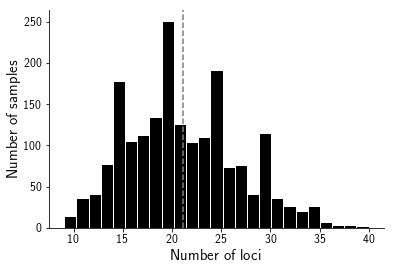

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(sampstats["numloci"], color="black", edgecolor="white", bins=25);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Number of loci", size=15)
ax.set_ylabel("Number of samples", size=15)
ax.set_xticklabels([int(x) for x in ax.get_xticks()], size=12)
ax.set_yticklabels([int(x) for x in ax.get_yticks()], size=12);
ax.axvline(x=np.mean(sampstats["numloci"]), color="gray", linestyle="dashed")
#fig.savefig(os.path.join(OUTPATH, "Figure1_LociPerSample.pdf"))

In [11]:
# Average calls/sample
np.mean(sampstats["numloci"])

21.095561357702351

# Figure 1C: Call rate per locus

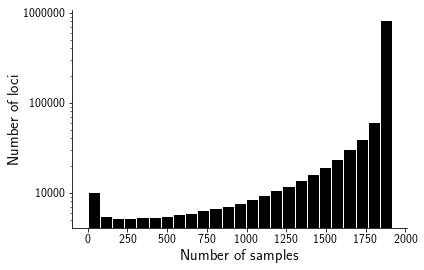

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
# Merge with hipstr reference so we get loci with 0 calls
locstats_all = pd.merge(hipstr, locstats, on=["chrom","start","end","period"], how="left")
locstats_all.ix[np.isnan(locstats_all["numcalls"]), "numcalls"] = 0
ax.hist(locstats["numcalls"], log=True, color="black", edgecolor="white", bins=25);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Number of samples", size=15)
ax.set_ylabel("Number of loci", size=15)
ax.set_xticklabels([int(x) for x in ax.get_xticks()], size=12)
ax.set_yticklabels([int(x) for x in ax.get_yticks()], size=12);
#fig.savefig(os.path.join(OUTPATH, "Figure1_SamplesPerLocus.png"))

In [5]:
# Overall call rate
1-locstats_all[locstats_all["numcalls"]==0].shape[0]/locstats_all.shape[0]

0.7517094559994342

In [7]:
# Average call rate
np.mean(locstats["numcalls"])/NUMSAMPLES

0.90443105378282229

In [35]:
# Loci remaining after filtering
locstats[locstats["FILTER"]=="."].shape[0]

355967

# Figure 1D: Mendelian inheritance

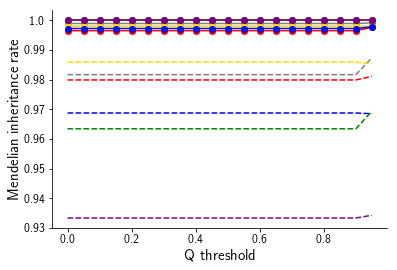

In [20]:
# Mendelian inheritance vs. qual
fig = plt.figure()
ax = fig.add_subplot(111)
scores = np.arange(0.0, 1, 0.05)

mend_pass = mend[(mend["FILTER"]==".")]
mend_fail = mend[(mend["FILTER"]!=".")]

for period in range(1, 7):
    mend_scores_pass = []
    mend_scores_fail = []
    for q in scores:
        x_pass = mend_pass[(mend_pass["Q"]>=q) & (mend_pass["period"]==period)]
        if x_pass.shape[0] >= 50:
            mend_scores_pass.append(np.mean(x_pass["mend"]))
        else: mend_scores_pass.append(np.nan)
        x_fail = mend_fail[(mend_fail["Q"]>=q) & (mend_fail["period"]==period)]
        if x_fail.shape[0] >= 50:
            mend_scores_fail.append(np.mean(x_fail["mend"]))
        else: mend_scores_fail.append(np.nan)
    ax.plot(scores, mend_scores_pass, color=colors[period-1], marker="o");
    ax.plot(scores, mend_scores_fail, color=colors[period-1], linestyle="dashed");
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Q threshold", size=15)
ax.set_ylabel("Mendelian inheritance rate", size=15)
ax.set_xticklabels([(x) for x in ax.get_xticks()], size=12)
ax.set_yticklabels([(x) for x in ax.get_yticks()], size=12);

In [23]:
# Average Mend. inheritance before filtering 
np.mean(mend_fail["mend"])

0.97627965043695386

In [22]:
# Average Mend. inheritance after filtering 
np.mean(mend_pass["mend"])

0.99816904196357881

# Figure 1E: Comparison to lobSTR heterozygosities

In [29]:
lobstr = pd.read_csv(os.path.join(DATAPATH, "lobstr_het_stats.tab"), sep="\t", names=["chrom","start","het_lobstr","numcalls"])
lobstr["chrom"] = lobstr["chrom"].apply(lambda x: str(x[3:]))
lobstr = lobstr[lobstr["numcalls"]>=MINLOB]
het = pd.merge(lobstr, locstats[["chrom","start","het","FILTER"]], on=["chrom","start"])
het = het[(het["FILTER"]==".") | (het["FILTER"]=="Het")]

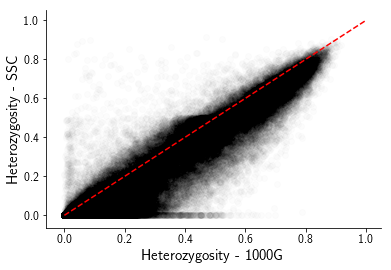

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(het["het_lobstr"], het["het"], color="black", alpha=0.01);
ax.plot([0,1],[0,1], linestyle="dashed", color="red")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Heterozygosity - 1000G", size=15)
ax.set_ylabel("Heterozygosity - SSC", size=15)
ax.set_xticklabels([(x) for x in ax.get_xticks()], size=12)
ax.set_yticklabels([(x) for x in ax.get_yticks()], size=12);
#fig.savefig(os.path.join(OUTPATH, "Figure1_Heterozygosities.png"))

In [34]:
# Correlation with lobSTR heterozygosities - TODO
r, p = scipy.stats.pearsonr(het["het_lobstr"], het["het"])
print("\t".join([str(item) for item in [r, p, het.shape[0]]]))

0.955714662425	0.0	302329


# Supplemental Figure: Length bias

In [7]:
reflen = range(10, 100, 1)
diffs = []
percs = []
for i in range(len(reflen)-1):
    lb = reflen[i]
    ub = reflen[i+1]
    x = locstats[(locstats["length"]>=lb) & (locstats["length"]<ub)]
    if x.shape[0] <= 25:
        diffs.append(np.nan)
    else:
        diffs.append(sum(x.apply(lambda x: x["mean_allele"]*x["numcalls"], 1))/sum(x["numcalls"]))
    percs.append(locstats[locstats["length"]<ub].shape[0]*1.0/locstats.shape[0])

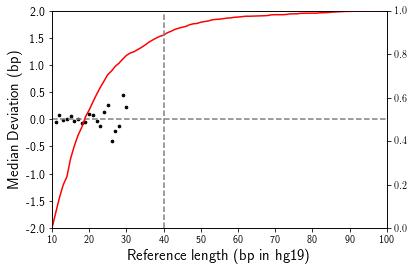

In [8]:
xmax = 100
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(reflen[:-1], diffs, color="black", s=7);
ax.set_xlabel("Reference length (bp in hg19)", size=15)
ax.set_ylabel("Median Deviation (bp)", size=15)
ax.set_ylim(bottom=-2, top=2)
ax.set_xlim(left=10, right=xmax)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.axhline(y=0, linestyle="dashed", color="gray")

ax2 = ax.twinx()
ax2.plot(reflen[:-1], percs, color="red");
ax2.set_ylim(bottom=0, top=1)
ax2.set_xlim(left=10, right=xmax)
ax2.set_xticklabels([int(x) for x in ax.get_xticks()], size=12);
ax2.axvline(x=40, linestyle="dashed", color="gray")